### BUAN 6340 Programming for Data Science
##### Group 1
##### Group Name : SAAB

## Melbourne Housing Prices

### Data Description
Number of observations: 13,580;
Missing data: 4.64% Categorical variables: 
CouncilArea, Regionname, Year Built;

URL: https://www.kaggle.com/datasets/dansbecker/melbourne-housing-snapshot

Variables/Columns:
1. Suburb: The name of the suburb the property is located in’
2. Address: The street address of the property
3. Rooms: The number of rooms in the property
4. Type: The type of property (h- house/cottage/etc, u - unit/duplex, t - townhouse)
5. Price: The price in dollars
6. Method: The type of listing
7. SellerG: The name of the real estate agent
8. Date: The date the property was sold
9. Distance: The distance to the central business district
10. Postcode: The postcode for the property
11. Bedroom2: The number of bedrooms (scraped from a different source)
12. Bathroom: The number of bathrooms
13. Car: The number of car parking spots for the property
14. Landsize: The size of the lot of land
15. BuildingArea: The size of the property (building specifically)
16. YearBuilt: The year built
17. CouncilArea: The governing council for the area
18. Latitude: A measure of how far north a house is; a higher value is farther north
19. Longitude: A measure of how far west a house is; a higher value is farther west
20. Regionname: Combination of general region and cardinal direction
21. Propertycount: The number of properties that exist in the suburb

### Motivation
The data set contains publicly available information posted on a weekly basis on Domain.com.au.

The increasing unaffordability of housing is a significant challenge for many cities in the world. To obtain an improved understanding of the current housing market, we would like to examine the top influential factors of housing prices to provide a model for more accurate estimations.

Our objective is to observe and examine major factors affecting housing prices and to obtain accurate predictions. Methods of statistical and machine learning regression models are applied to obtain predictions and estimates.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import warnings
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing  import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
from sklearn import tree

In [2]:
# Data Loading
house = pd.read_csv('melb_data.csv')
house.describe()
house.head()

Suburb           Address  Rooms Type      Price Method SellerG  \
0  Abbotsford      85 Turner St      2    h  1480000.0      S  Biggin   
1  Abbotsford   25 Bloomburg St      2    h  1035000.0      S  Biggin   
2  Abbotsford      5 Charles St      3    h  1465000.0     SP  Biggin   
3  Abbotsford  40 Federation La      3    h   850000.0     PI  Biggin   
4  Abbotsford       55a Park St      4    h  1600000.0     VB  Nelson   

        Date  Distance  Postcode  ...  Bathroom  Car  Landsize  BuildingArea  \
0  3/12/2016       2.5    3067.0  ...       1.0  1.0     202.0           NaN   
1  4/02/2016       2.5    3067.0  ...       1.0  0.0     156.0          79.0   
2  4/03/2017       2.5    3067.0  ...       2.0  0.0     134.0         150.0   
3  4/03/2017       2.5    3067.0  ...       2.0  1.0      94.0           NaN   
4  4/06/2016       2.5    3067.0  ...       1.0  2.0     120.0         142.0   

   YearBuilt  CouncilArea Lattitude  Longtitude             Regionname  \
0        NaN        Yarra  -37.7996    144.9984  Northern Metropolitan   
1     1900.0        Yarra  -37.8079    144.9934  Northern Metropolitan   
2     1900.0        Yarra  -37.8093    144.9944  Northern Metropolitan   
3        NaN        Yarra  -37.7969    144.9969  Northern Metropolitan   
4     2014.0        Yarra  -37.8072    144.9941  Northern Metropolitan   

  Propertycount  
0        4019.0  
1        4019.0  
2        4019.0  
3        4019.0  
4        4019.0  

[5 rows x 21 columns]

### Data Cleansing

In [3]:
house.columns[house.isnull().any()]

Index(['Car', 'BuildingArea', 'YearBuilt', 'CouncilArea'], dtype='object')

In [4]:
# check for duplicates
print('Duplicate Rows:', house.duplicated().sum())

Duplicate Rows: 0


In [5]:
# binning for long/lat into buckets
step = 0.2
to_bin = lambda x: np.floor(x / step) * step
house["latBin"] = to_bin(house.Lattitude)
house["lonBin"] = to_bin(house.Longtitude)
groups = house.groupby(["latBin", "lonBin"])

In [6]:
# num of nulls on each column
house.isna().sum().sort_values(ascending = False)

BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Car                62
Suburb              0
latBin              0
Propertycount       0
Regionname          0
Longtitude          0
Lattitude           0
Landsize            0
Bathroom            0
Address             0
Bedroom2            0
Postcode            0
Distance            0
Date                0
SellerG             0
Method              0
Price               0
Type                0
Rooms               0
lonBin              0
dtype: int64

In [7]:
#populate missing values based on mean of lan and lat
house = house.groupby(['latBin', 'lonBin']).apply(
    lambda grp: grp.fillna(np.mean(grp))
)

In [8]:
# num of nulls on each column
house.isna().sum().sort_values(ascending = False)

CouncilArea      1369
Suburb              0
Car                 0
latBin              0
Propertycount       0
Regionname          0
Longtitude          0
Lattitude           0
YearBuilt           0
BuildingArea        0
Landsize            0
Bathroom            0
Address             0
Bedroom2            0
Postcode            0
Distance            0
Date                0
SellerG             0
Method              0
Price               0
Type                0
Rooms               0
lonBin              0
dtype: int64

In [9]:
house.reset_index(drop = True, inplace = True)

In [10]:
#populate missing values in CouncilArea with mode base on lat and long
house['CouncilArea'] = house.groupby(['latBin', 'lonBin']).CouncilArea.transform(lambda x: x.fillna(x.mode()[0]))


In [11]:
# num of nulls on each column
house.isna().sum().sort_values(ascending = False)

Suburb           0
Car              0
latBin           0
Propertycount    0
Regionname       0
Longtitude       0
Lattitude        0
CouncilArea      0
YearBuilt        0
BuildingArea     0
Landsize         0
Bathroom         0
Address          0
Bedroom2         0
Postcode         0
Distance         0
Date             0
SellerG          0
Method           0
Price            0
Type             0
Rooms            0
lonBin           0
dtype: int64

### Data Preparation

In [12]:
#convert house build to int
house['YearBuilt'] = house['YearBuilt'].astype('int')
house['Date'] = pd.to_datetime(house['Date'], format = '%d/%m/%Y')
house['YEAR'] = pd.DatetimeIndex(house['Date']).year
house['MONTH'] = pd.DatetimeIndex(house['Date']).month

In [13]:
house['YearBuilt']

0        1977
1        1960
2        1960
3        1977
4        1977
         ... 
13575    1996
13576    2007
13577    2011
13578    2007
13579    2012
Name: YearBuilt, Length: 13580, dtype: int32

In [14]:
from datetime import datetime, date
now = pd.Timestamp('now').year  
house['AGE'] = now-house['YearBuilt'] 

house = house.drop('Address',axis=1)
house = house.drop('Date',axis=1)


In [15]:
#Convert column names to upper case 
house.columns= [x.upper() for x in house.columns]
#print(house.columns)
print(house.head(20))

             SUBURB  ROOMS TYPE      PRICE METHOD        SELLERG  DISTANCE  \
0         Frankston      3    h   640000.0      S  hockingstuart      38.0   
1   Frankston North      3    h   611000.0      S            Ray      36.9   
2   Frankston South      3    h   755000.0      S  hockingstuart      38.0   
3       Keysborough      4    h   965000.0      S            Ray      25.2   
4        Mordialloc      4    h   800000.0     PI            Ray      21.5   
5           Seaford      3    u   572000.0      S        O'Brien      35.4   
6              Skye      4    h   640000.0     VB  hockingstuart      34.7   
7          Bonbeach      3    h   836000.0      S            Ray      27.0   
8            Carrum      4    h   965000.0     SP         Buxton      31.2   
9            Carrum      2    u   529000.0      S         Buxton      31.2   
10           Carrum      3    h   881000.0      S            Ray      31.2   
11           Carrum      4    h   845000.0     PI         Buxton

In [16]:
house.columns

Index(['SUBURB', 'ROOMS', 'TYPE', 'PRICE', 'METHOD', 'SELLERG', 'DISTANCE',
       'POSTCODE', 'BEDROOM2', 'BATHROOM', 'CAR', 'LANDSIZE', 'BUILDINGAREA',
       'YEARBUILT', 'COUNCILAREA', 'LATTITUDE', 'LONGTITUDE', 'REGIONNAME',
       'PROPERTYCOUNT', 'LATBIN', 'LONBIN', 'YEAR', 'MONTH', 'AGE'],
      dtype='object')

In [17]:
tot_instances = house.shape[0]
threshold = tot_instances*.005
threshold

67.9

In [18]:
obj_columns = list(house.select_dtypes(include=['object']).columns)
obj_columns

['SUBURB', 'TYPE', 'METHOD', 'SELLERG', 'COUNCILAREA', 'REGIONNAME']

In [19]:
house = house.apply(lambda x: x.mask(x.map(x.value_counts())<threshold, 'RARE') if x.name in obj_columns else x)

In [20]:
# one hot encoding
house_type = pd.get_dummies(house['TYPE'],prefix='TYPE')
house = house.drop('TYPE',axis=1)
house = house.join(house_type)


house_method = pd.get_dummies(house['METHOD'],prefix='METHOD')
house = house.drop('METHOD',axis=1)
house = house.join(house_method)


house_reg = pd.get_dummies(house['REGIONNAME'],prefix='REGIONNAME')
house = house.drop('REGIONNAME',axis=1)
house = house.join(house_reg)


house_post = pd.get_dummies(house['POSTCODE'],prefix='POSTCODE')
house = house.drop('POSTCODE',axis=1)
house = house.join(house_post)


house_council = pd.get_dummies(house['COUNCILAREA'],prefix='COUNCILAREA')
house = house.drop('COUNCILAREA',axis=1)
house = house.join(house_council)


house_suburb = pd.get_dummies(house['SUBURB'],prefix='SUBURB')
house = house.drop('SUBURB',axis=1)
house = house.join(house_suburb)

house_sellerg = pd.get_dummies(house['SELLERG'],prefix='SELLERG')
house = house.drop('SELLERG',axis=1)
house = house.join(house_sellerg)






In [21]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
house_num = house.select_dtypes(include=numerics)
house_num

ROOMS     PRICE  DISTANCE  BEDROOM2  BATHROOM  CAR  LANDSIZE  \
0          3  640000.0      38.0       3.0       2.0  1.0     368.0   
1          3  611000.0      36.9       3.0       2.0  1.0     691.0   
2          3  755000.0      38.0       3.0       1.0  2.0     786.0   
3          4  965000.0      25.2       4.0       2.0  2.0     576.0   
4          4  800000.0      21.5       4.0       3.0  3.0     638.0   
...      ...       ...       ...       ...       ...  ...       ...   
13575      3  601000.0      35.5       3.0       2.0  1.0     972.0   
13576      4  555000.0      25.9       4.0       2.0  2.0     387.0   
13577      3  481000.0      25.9       3.0       2.0  1.0     359.0   
13578      3  430000.0      25.9       3.0       2.0  2.0     180.0   
13579      3  547000.0      25.9       3.0       2.0  2.0     410.0   

       BUILDINGAREA  YEARBUILT  LATTITUDE  LONGTITUDE  PROPERTYCOUNT  LATBIN  \
0        171.203625       1977  -38.15230   145.11874        17055.0   -38.2   
1        109.000000       1960  -38.11948   145.14928         2500.0   -38.2   
2        174.000000       1960  -38.16492   145.12656         7566.0   -38.2   
3        171.203625       1977  -38.00293   145.16465         8459.0   -38.2   
4        171.203625       1977  -38.00406   145.09502         3650.0   -38.2   
...             ...        ...        ...         ...            ...     ...   
13575    149.000000       1996  -37.51232   145.13282         2170.0   -37.6   
13576    163.750000       2007  -37.59589   145.11364         7254.0   -37.6   
13577    150.000000       2011  -37.58750   145.11884         7254.0   -37.6   
13578    163.750000       2007  -37.59827   145.07939         5812.0   -37.6   
13579    135.000000       2012  -37.59665   145.08877         5812.0   -37.6   

       LONBIN  YEAR  MONTH  AGE  
0       145.0  2017      7   45  
1       145.0  2017      7   62  
2       145.0  2017      7   62  
3       145.0  2017      7   45  
4       145.0  2017      7   45  
...       ...   ...    ...  ...  
13575   145.0  2017      7   26  
13576   145.0  2017      9   15  
13577   145.0  2017      9   11  
13578   145.0  2017      8   15  
13579   145.0  2017      8   10  

[13580 rows x 17 columns]

### Visualization Techniques

In [22]:
# Descriptive Summary Statistics (of numerical variables)
num_list = house.select_dtypes([np.int64, np.float64, np.int32]).columns
house[num_list].describe()

ROOMS         PRICE      DISTANCE      BEDROOM2      BATHROOM  \
count  13580.000000  1.358000e+04  13580.000000  13580.000000  13580.000000   
mean       2.937997  1.075684e+06     10.137776      2.914728      1.534242   
std        0.955748  6.393107e+05      5.868725      0.965921      0.691712   
min        1.000000  8.500000e+04      0.000000      0.000000      0.000000   
25%        2.000000  6.500000e+05      6.100000      2.000000      1.000000   
50%        3.000000  9.030000e+05      9.200000      3.000000      1.000000   
75%        3.000000  1.330000e+06     13.000000      3.000000      2.000000   
max       10.000000  9.000000e+06     48.100000     20.000000      8.000000   

                CAR       LANDSIZE  BUILDINGAREA     YEARBUILT     LATTITUDE  \
count  13580.000000   13580.000000  13580.000000  13580.000000  13580.000000   
mean       1.609551     558.416127    153.948820   1964.563549    -37.809203   
std        0.960572    3990.669241    466.878614     29.295335      0.079260   
min        0.000000       0.000000      0.000000   1196.000000    -38.182550   
25%        1.000000     177.000000    118.975286   1958.000000    -37.856822   
50%        2.000000     440.000000    134.200516   1962.000000    -37.802355   
75%        2.000000     651.000000    162.000000   1979.000000    -37.756400   
max       10.000000  433014.000000  44515.000000   2018.000000    -37.408530   

         LONGTITUDE  PROPERTYCOUNT        LATBIN        LONBIN          YEAR  \
count  13580.000000   13580.000000  13580.000000  13580.000000  13580.000000   
mean     144.995216    7454.417378    -37.903638    144.899647   2016.533432   
std        0.103916    4378.581772      0.107957      0.122629      0.498899   
min      144.431810     249.000000    -38.200000    144.400000   2016.000000   
25%      144.929600    4380.000000    -38.000000    144.800000   2016.000000   
50%      145.000100    6555.000000    -38.000000    145.000000   2017.000000   
75%      145.058305   10331.000000    -37.800000    145.000000   2017.000000   
max      145.526350   21650.000000    -37.600000    145.400000   2017.000000   

              MONTH           AGE  
count  13580.000000  13580.000000  
mean       7.052283     57.436451  
std        2.536034     29.295335  
min        1.000000      4.000000  
25%        5.000000     43.000000  
50%        7.000000     60.000000  
75%        9.000000     64.000000  
max       12.000000    826.000000

In [23]:
#'LATTITUDE', 'LONGTITUDE', LATBIN', 'LONBIN'
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
house_num = house.select_dtypes(include=numerics)
house_num

ROOMS     PRICE  DISTANCE  BEDROOM2  BATHROOM  CAR  LANDSIZE  \
0          3  640000.0      38.0       3.0       2.0  1.0     368.0   
1          3  611000.0      36.9       3.0       2.0  1.0     691.0   
2          3  755000.0      38.0       3.0       1.0  2.0     786.0   
3          4  965000.0      25.2       4.0       2.0  2.0     576.0   
4          4  800000.0      21.5       4.0       3.0  3.0     638.0   
...      ...       ...       ...       ...       ...  ...       ...   
13575      3  601000.0      35.5       3.0       2.0  1.0     972.0   
13576      4  555000.0      25.9       4.0       2.0  2.0     387.0   
13577      3  481000.0      25.9       3.0       2.0  1.0     359.0   
13578      3  430000.0      25.9       3.0       2.0  2.0     180.0   
13579      3  547000.0      25.9       3.0       2.0  2.0     410.0   

       BUILDINGAREA  YEARBUILT  LATTITUDE  LONGTITUDE  PROPERTYCOUNT  LATBIN  \
0        171.203625       1977  -38.15230   145.11874        17055.0   -38.2   
1        109.000000       1960  -38.11948   145.14928         2500.0   -38.2   
2        174.000000       1960  -38.16492   145.12656         7566.0   -38.2   
3        171.203625       1977  -38.00293   145.16465         8459.0   -38.2   
4        171.203625       1977  -38.00406   145.09502         3650.0   -38.2   
...             ...        ...        ...         ...            ...     ...   
13575    149.000000       1996  -37.51232   145.13282         2170.0   -37.6   
13576    163.750000       2007  -37.59589   145.11364         7254.0   -37.6   
13577    150.000000       2011  -37.58750   145.11884         7254.0   -37.6   
13578    163.750000       2007  -37.59827   145.07939         5812.0   -37.6   
13579    135.000000       2012  -37.59665   145.08877         5812.0   -37.6   

       LONBIN  YEAR  MONTH  AGE  
0       145.0  2017      7   45  
1       145.0  2017      7   62  
2       145.0  2017      7   62  
3       145.0  2017      7   45  
4       145.0  2017      7   45  
...       ...   ...    ...  ...  
13575   145.0  2017      7   26  
13576   145.0  2017      9   15  
13577   145.0  2017      9   11  
13578   145.0  2017      8   15  
13579   145.0  2017      8   10  

[13580 rows x 17 columns]

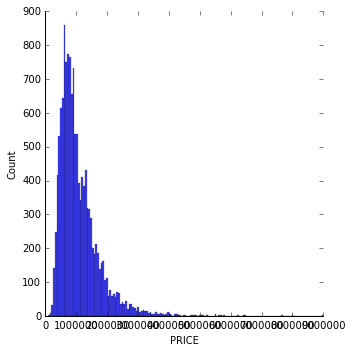

In [24]:
sns.displot(house['PRICE'])
plt.ioff()

AxesSubplot(0.125,0.125;0.775x0.775)


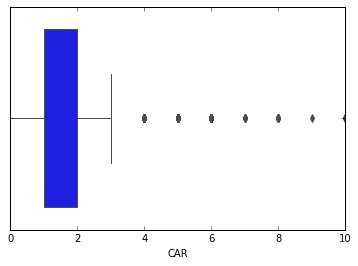

In [25]:
print(sns.boxplot(x=house['CAR']))

AxesSubplot(0.125,0.125;0.775x0.775)


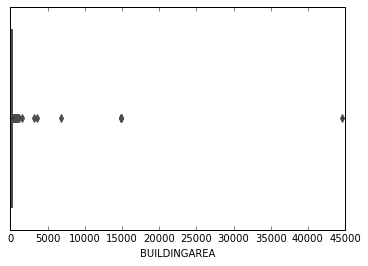

In [26]:
print(sns.boxplot(x=house['BUILDINGAREA']))

In [27]:
# outliers for BUILDINGAREA
for x in ['BUILDINGAREA']:
    q75,q25 = np.percentile(house.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    house.loc[house[x] < min,x] = np.nan
    house.loc[house[x] > max,x] = np.nan

AxesSubplot(0.125,0.125;0.775x0.775)


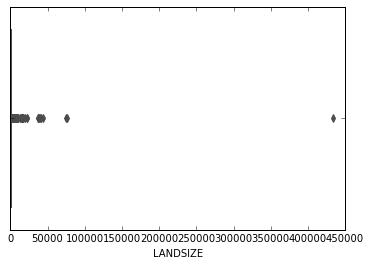

In [28]:
print(sns.boxplot(x=house['LANDSIZE']))

In [29]:
# outliers for LANDSIZE
for x in ['LANDSIZE']:
    q75,q25 = np.percentile(house.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    house.loc[house[x] < min,x] = np.nan
    house.loc[house[x] > max,x] = np.nan

AxesSubplot(0.125,0.125;0.775x0.775)


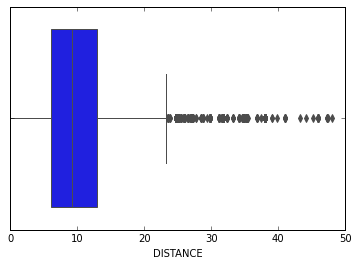

In [30]:
print(sns.boxplot(x=house['DISTANCE']))

In [31]:
# outliers for DISTANCE
for x in ['DISTANCE']:
    q75,q25 = np.percentile(house.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    house.loc[house[x] < min,x] = np.nan
    house.loc[house[x] > max,x] = np.nan

AxesSubplot(0.125,0.125;0.775x0.775)


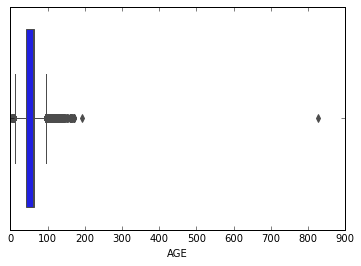

In [32]:
print(sns.boxplot(x=house['AGE']))

In [33]:
# outliers for AGE
for x in ['AGE']:
    q75,q25 = np.percentile(house.loc[:,x],[75,25])
    intr_qr = q75-q25
 
    max = q75+(1.5*intr_qr)
    min = q25-(1.5*intr_qr)
 
    house.loc[house[x] < min,x] = np.nan
    house.loc[house[x] > max,x] = np.nan

AxesSubplot(0.125,0.125;0.775x0.775)


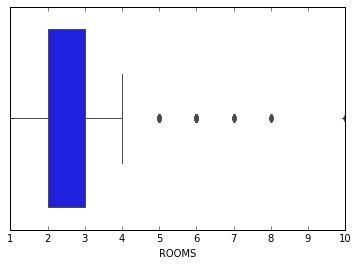

In [34]:
print(sns.boxplot(x=house['ROOMS']))

AxesSubplot(0.125,0.125;0.775x0.775)


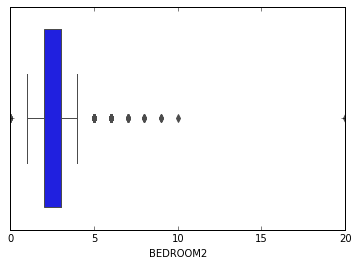

In [35]:
print(sns.boxplot(x=house['BEDROOM2']))

In [36]:
step = 0.2
to_bin = lambda x: np.floor(x / step) * step
house["latBin"] = to_bin(house.LATTITUDE)
house["lonBin"] = to_bin(house.LONGTITUDE)
groups = house.groupby(["latBin", "lonBin"])

#populate missing values based on mean of lan and lat
house = house.groupby(['latBin', 'lonBin']).apply(
    lambda grp: grp.fillna(np.mean(grp))
)

In [37]:
# fills remaining missings with mean of Distance
house['DISTANCE'] = house['DISTANCE'].fillna(house['DISTANCE'].mean())

In [38]:
# num of nulls on each column
house.isna().sum().sort_values(ascending = False)

ROOMS                      0
SUBURB_Brunswick           0
COUNCILAREA_Maroondah      0
COUNCILAREA_Maribyrnong    0
COUNCILAREA_Manningham     0
                          ..
POSTCODE_3111.0            0
POSTCODE_3109.0            0
POSTCODE_3108.0            0
POSTCODE_3107.0            0
lonBin                     0
Length: 355, dtype: int64

#### Plot again after handling outliers

AxesSubplot(0.125,0.125;0.775x0.775)


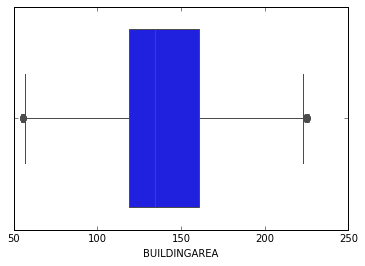

In [39]:
print(sns.boxplot(x=house['BUILDINGAREA']))

AxesSubplot(0.125,0.125;0.775x0.775)


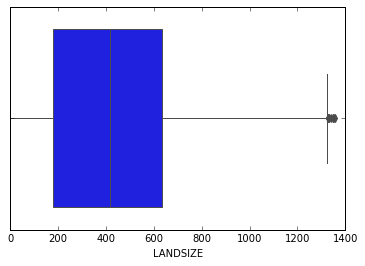

In [40]:
print(sns.boxplot(x=house['LANDSIZE']))

AxesSubplot(0.125,0.125;0.775x0.775)


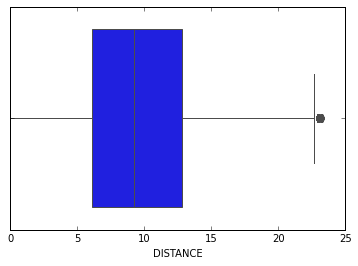

In [41]:
print(sns.boxplot(x=house['DISTANCE']))

AxesSubplot(0.125,0.125;0.775x0.775)


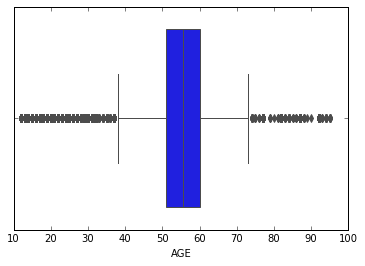

In [42]:
print(sns.boxplot(x=house['AGE']))

In [43]:
house[house.select_dtypes(np.float64).columns] = house.select_dtypes(np.float64).astype(np.float32)

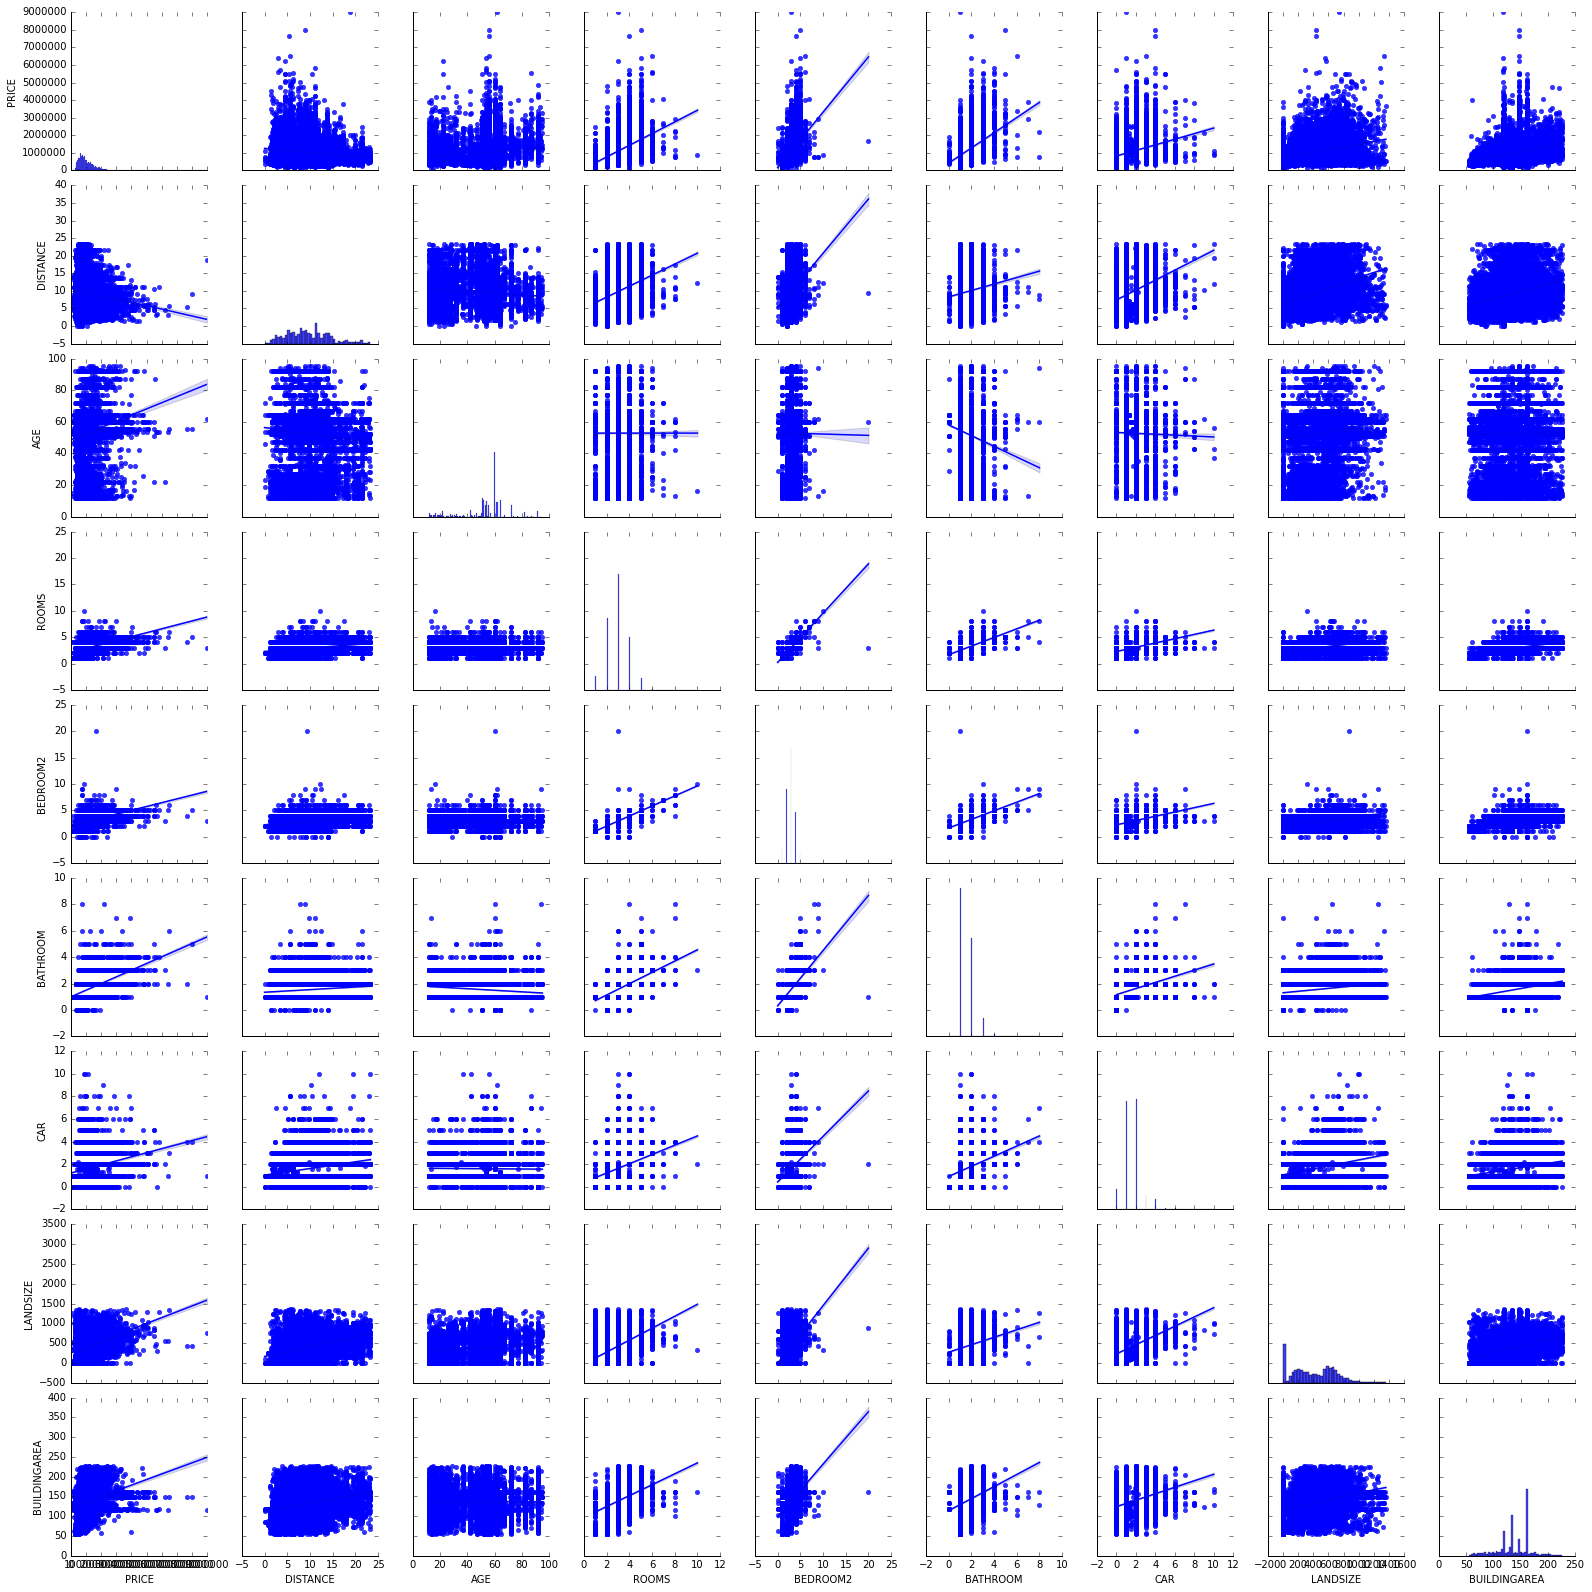

In [44]:
sns.pairplot(data = house, vars=['PRICE','DISTANCE','AGE','ROOMS','BEDROOM2','BATHROOM','CAR', 'LANDSIZE', 'BUILDINGAREA'],kind='reg')
plt.show()

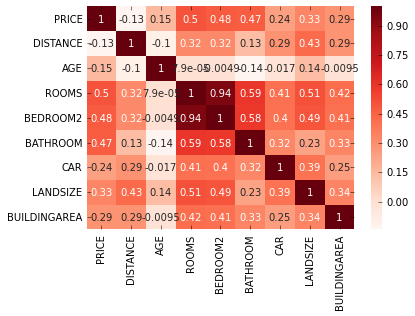

In [45]:
#plot the correlation matrix of ROOMS, BEDROOM2, BATHROOM,CAR, LANDSIZE and BUILDINGAREA in data dataframe.
sns.heatmap(house[['PRICE','DISTANCE','AGE','ROOMS','BEDROOM2','BATHROOM','CAR', 'LANDSIZE', 'BUILDINGAREA']].corr(), annot=True, cmap = 'Reds')
plt.show()

### Regression Analysis

In [46]:
from sklearn.preprocessing import StandardScaler
scaling = StandardScaler()
X = house.loc[:, ~house.columns.isin(['PRICE','YEARBUILT'])]
y=scaling.fit_transform(house[['PRICE']])


In [47]:
# Data splitting for training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,     
    test_size = 0.3, random_state = 42 )

#### Linear Regression

In [48]:
# create an object of linear regression
model = LinearRegression()

# Train the model using the training set
model.fit(X_train, y_train)

LinearRegression()

In [49]:
# Test set prediction
y_pred = model.predict(X_test)
## MAE - test
# Test set residual
e = y_test - y_pred
#print(e)
# Test set MAE
mae_test = np.sum(np.abs(e))/y_test.shape[0]
mae_test

0.34954813151079644

In [50]:
## MSE - test

# Test set MSE
mse_test = np.sum(np.square(e))/y_test.shape[0]
print('mse_test: ',mse_test)

## RMSE - test
# Test set RMSE
print('RMSE: ',mse_test**0.50)

model.score(X_test, y_test)

mse_test:  0.26835671841459074
RMSE:  0.5180315805185922


0.7168587745014965

#### Ridge Regression

In [51]:
# Define Ridge model
ridge = Ridge(alpha = 1)

# train the model
ridge.fit(X_train, y_train)

# R-square for test set
R2_test_ridge = ridge.score(X_test, y_test)
print('R squared ridge : ', R2_test_ridge)

R squared ridge :  0.7160293845611638


#### Lasso Regression

In [52]:
# Lasso regression model. Hyper-tune its parameters. Evaluate the performance.
from sklearn.linear_model import Lasso

# Define model-alpha = 100
my_lasso = Lasso(alpha=100)

my_lasso.fit(X_train, y_train)

# prediction on test
y_pred_test_lasso = my_lasso.predict(X_test)

# Estimated coefficients and intercept
print('Coeffficents : ', my_lasso.coef_)
print('Intercept : ', my_lasso.intercept_)

# mse for test set
mse_lasso = np.sum((y_pred_test_lasso - y_test)**2)/y_pred_test_lasso.shape[0]
print('MSE lasso:', mse_lasso)

# R-square for test set
R2_test_lasso = my_lasso.score(X_test, y_test)
print('R squared lasso:', R2_test_lasso)

Coeffficents :  [ 0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -0.0000000e+00
  0.0000000e+00 -3.6773108e-06 -0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00  0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00  0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000000e+00 -0.0000000e+00  0.0000000e+00 -0.0000000e+00
  0.0000000e+00 -0.0000000e+00 -0.0000000e+00 -0.0000000e+00
 -0.0000

#### Polynomial Regression

In [53]:
# polynomial regression
param_poly = {'polynomialfeatures__degree' : range(1, 5)  }

poly_cv = make_pipeline(PolynomialFeatures() , LinearRegression())

grid_poly = GridSearchCV( poly_cv,  param_poly, cv = 5)

grid_poly.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures()),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'polynomialfeatures__degree': range(1, 5)})

In [54]:
# Report the coefficients (including the intercept)
print('Intercept:',grid_poly.best_estimator_.named_steps['linearregression'].intercept_)
print('Coefs:',grid_poly.best_estimator_.named_steps['linearregression'].coef_)

# chosen hyperparameter (i.e., polynomial degree)
print('Chosen Hyperparamter:', grid_poly.best_estimator_.named_steps['polynomialfeatures'].degree)

# and the model performance (based on default measure, R-squared)
print('Model Performance:', grid_poly.best_score_)

Intercept: [-73.58591436]
Coefs: [[ 5.93353071e-12  2.19734439e-01 -2.74134582e-02  1.93387189e-02
   2.49688210e-01  5.32182575e-02  6.21306870e-04  2.18725421e-04
  -4.87795244e+00 -2.83399462e+00  9.99469821e-06 -3.49597916e-01
   6.64804778e-04  1.34744573e-01  1.31369340e-02  4.13995440e-04
   3.57230884e-01 -1.70513299e-02 -3.40179554e-01 -4.49963035e-02
   9.95847124e-02 -7.64779571e-02  3.74314603e-02 -1.55419121e-02
   4.41208636e-01  2.07380258e-01  5.34611144e-01 -1.65170216e-01
  -3.36690885e-01 -6.81338937e-01  1.02437053e-01  1.48032609e+00
   2.38508542e-01  4.80994056e-01  5.07928793e-01  4.47795089e-01
   2.86259505e-01  1.13379590e-02  7.24700504e-02  2.01297767e-01
  -6.38117629e-02  3.50748375e-03  1.02842318e-01 -1.80490526e-01
  -3.37419424e-01 -3.34447378e-01 -9.59291205e-01 -3.27868126e-01
  -3.69299489e-01 -7.45333872e-01 -6.26176718e-01 -9.38821619e-01
  -4.79047346e-02  1.01836849e+00  4.11810030e-02 -5.56304323e-02
   1.99994766e-01 -1.85076771e-01 -1.718097

### Classification Techniques

In [55]:
# Classification section
def my_func(row):
    if row['PRICE'] < 1045000:
        val = 0
    else:
        val = 1
    return val
house['PRICE_c'] = house.apply(my_func, axis=1)
house[['PRICE','PRICE_c']].head()
# classification
X = house.loc[:, ~house.columns.isin(['PRICE','PRICE_c'])]#,'YEARBUILT'
y=house['PRICE_c']

In [56]:
# Data splitting for training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,    
    test_size = 0.3, random_state = 42 )

#### Logistic Regression

In [57]:
#logistic regression model
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
print('Coefficients : ', logreg.coef_)
print('Intercept : ', logreg.intercept_)

Coefficients :  [[ 5.73158224e-02 -2.33535451e-01  5.55917115e-02  4.99864604e-02
   1.90616109e-02  2.88250242e-03  3.04686155e-02 -2.23036932e-02
  -4.79618285e-03  4.99640556e-03 -3.17636191e-05 -5.80263274e-03
   4.42982654e-03  1.85237486e-02  1.33075046e-02 -4.14045015e-03
   1.96494455e-02  3.16662959e-03 -2.28063350e-02  1.38997469e-03
   3.13774024e-03 -4.32999175e-04 -6.25728845e-03  2.17231275e-03
  -5.08080435e-05 -1.23462992e-02 -2.04733202e-03 -3.48434461e-03
   3.32549458e-02 -1.53164219e-02 -3.53380698e-05  9.92866185e-05
   1.11305405e-04 -1.10999888e-04 -2.93329984e-05 -1.39085364e-03
  -2.32042933e-03  1.00969686e-04 -2.21611166e-04  1.21446793e-03
  -3.57029646e-07 -6.62827033e-04 -4.82252674e-03 -8.27965769e-04
  -3.78943773e-05 -5.24218909e-04 -5.76732485e-05 -6.03890276e-04
  -2.55713867e-05 -1.72359699e-04 -5.94661837e-04 -8.70232206e-04
  -4.33863177e-04 -6.97695596e-05 -1.34926909e-03 -8.38562930e-04
  -1.46203940e-04 -2.97000060e-04 -6.94227714e-04  7.4420577

In [58]:
# predict first
y_pred = logreg.predict(X_test)

# Confusion Matrix: 
TP = np.sum((y_test == 1) & (y_pred == 1)) # true positive
TN = np.sum((y_test == 0) & (y_pred == 0)) # true negative
FP = np.sum((y_test == 0) & (y_pred == 1)) # false positive
FN = np.sum((y_test == 1) & (y_pred == 0)) # false negative
print(TP, TN, FP, FN)

1034 2089 367 584


In [59]:
# Accuracy
(TP+TN)/(TP+TN+FP+FN)

0.7665684830633285

In [60]:
# Precision
(TP/(TP+FP))

0.7380442541042113

In [61]:
# Recall
(TP/(TP+FN))

0.6390605686032138

In [62]:
# Create a variable, prob_predicted, which is the predicted probability of the test set.
prob_predicted = logreg.predict_proba(X_test)
prob_predicted

array([[0.16605355, 0.83394645],
       [0.49681151, 0.50318849],
       [0.36479111, 0.63520889],
       ...,
       [0.71319738, 0.28680262],
       [0.09074936, 0.90925064],
       [0.97615387, 0.02384613]])

#### K-NN Classification Model

In [63]:
# KNN Model
from sklearn.neighbors import KNeighborsClassifier
# Define objective, train the model.
n_neighbors = 3
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)
# Do prediction, get accuracy
## prediction: knn.predict(X_test)
knn.score(X_test, y_test)


0.802405498281787

In [64]:
from sklearn.model_selection import GridSearchCV

# define function
base_knn = KNeighborsClassifier()

# define a list of parameters
param_knn = {'n_neighbors': range(3, 27, 2)}  # exactly the same as the input variable name. 

#apply grid search
grid_knn = GridSearchCV(base_knn, param_knn, cv = 5)
grid_knn.fit(X_train, y_train) # this line will take time. To get results quickly, start a new cell

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(3, 27, 2)})

In [65]:
# the best hyperparameter chosen:
print(grid_knn.best_params_)

# When best case, the validation score of through CV is:
print(grid_knn.best_score_)

# For each different grid, show the mean test(validation) score and mean training score (across 5 folds CV)
grid_knn.cv_results_['mean_test_score']

# Show how best_score is obtained
grid_knn.cv_results_['mean_test_score'].max()

# most important - Final model performance on Test set
grid_knn.score(X_test, y_test)


{'n_neighbors': 3}
0.804020795961614


0.802405498281787

#### Decision Tree Model

In [66]:
from sklearn.tree import DecisionTreeClassifier

# A Basic Tree

clf_tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)

# Train the Model
clf_tree.fit(X_train, y_train)

# Obtain and print accuracy
clf_tree.score(X_test, y_test)

clf_tree.feature_importances_
#target_names
house.feature_names = X.columns
house.target_names = 'PRICE_c'

In [67]:
# Plot the decision tree
from sklearn import tree

# set a proper figure size (in case that the figure is too small to read or ratio is not proper)
fig = plt.figure(figsize=(200,100))

tree.plot_tree(clf_tree, 
               feature_names = house.feature_names, # specify variable names 
               class_names = house.target_names, # specify class (Y) names
               filled = True, # whether to color the boxes
               impurity = False, # whether to report gini index
               fontsize = 10) # set fontsize to read
plt.show()

# save the figure to read through the boxes, it is saved under the same directory as the coding doc.
fig.savefig("decision_tree_basic.jpg")